# Notebook to generate model identifiability plot

This notebook requires the modeling results data, saved in
`../../cache/phys_modeling_logs/synthetic`. This can be downloaded from the
OSF repo or can be generated by training the models yourself.

In [19]:
"""Imports."""

import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as scipy_stats

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [28]:
"""Load results."""

BASE_RESULTS_DIR = Path("../../../cache/modeling/synthetic")
SEEDS = [3, 4, 5, 6, 7]
MODEL_ORDER = ["Slot", "Switching", "Gain"]
DATASET_DIRS = {
    "Slot": "triangle_slot_partition",
    "Switching": "triangle_switching",
    "Gain": "triangle_gain",
}
MODEL_DIRS = {
    "Slot": "triangle_slot_partition",
    "Switching": "triangle_switching",
    "Gain": "triangle_gain",
}
SUBJECT_SESSIONS = [
    ("Elgar", "2022-08-19"),
    ("Elgar", "2022-08-20"),
    ("Elgar", "2022-08-22"),
    ("Elgar", "2022-08-24"),
    ("Elgar", "2022-09-04"),
    ("Perle", "2022-05-30"),
    ("Perle", "2022-05-31"),
    ("Perle", "2022-06-01"),
    ("Perle", "2022-06-03"),
    ("Perle", "2022-06-04"),
]

# Bootstrap function
def _compute_bootstrap_probs(ll_per_model, trials_per_bootstrap=300, n_bootstrap=1000):
    """Compute bootstrap probabilities."""
    # Get log-likelihoods
    models = list(ll_per_model.keys())
    ll_per_model_array = np.array([ll_per_model[k] for k in models])
    
    # Compute bootstrap probabilities
    probs_per_bootstrap = []
    for _ in range(n_bootstrap):
        trials = np.random.choice(
            ll_per_model_array.shape[1],
            size=trials_per_bootstrap,
            replace=True,
        )
        ll_bootstrap = np.sum(ll_per_model_array[:, trials], axis=1)
        ll_bootstrap = ll_bootstrap - ll_bootstrap.min()
        probs = np.exp(ll_bootstrap) / np.sum(np.exp(ll_bootstrap))
        probs_per_bootstrap.append(probs)
    
    # Return mean over bootstraps
    probs_per_bootstrap = {
        k: [x[i] for x in probs_per_bootstrap]
        for i, k in enumerate(models)
    }
    return probs_per_bootstrap

# Get data
data_df = {
    "dataset": [],
    "subject": [],
    "session": [],
    "num_neurons": [],
    "seed": [],
    "model": [],
    "prob": [],
}
for dataset in MODEL_ORDER:
    for subject, session in SUBJECT_SESSIONS:
        for seed in SEEDS:
            # Get data per model
            test_ll_stats_per_model = {}
            num_neurons_per_model = {}
            for model in MODEL_ORDER:
                model_dir = MODEL_DIRS[model]
                dataset_dir = DATASET_DIRS[dataset]
                log_dir = BASE_RESULTS_DIR / dataset_dir / model_dir / subject / session / str(seed)
                if not log_dir.exists():
                    raise ValueError(f"Log directory {log_dir} does not exist.")
                test_ll_stats = json.load(open(log_dir / "stop_step" / "eval_stats.json"))
                test_ll_stats_per_model[model] = test_ll_stats
                num_neurons = json.load(open(log_dir / "test_metrics.json"))[0]["num_neurons"]
                num_neurons_per_model[model] = num_neurons
            
            # Validate have same trials per unit for each model
            trials_per_unit_str = {
                k: str(v["trials_per_unit"])
                for k, v in test_ll_stats_per_model.items()
            }
            trials_per_unit = set(trials_per_unit_str.values())
            if len(trials_per_unit) != 1:
                raise ValueError(f"Trials per unit mismatch: {trials_per_unit_str}")
            
            # Compute probabilities per model
            ll_per_model = {}
            for model, test_ll_stats in test_ll_stats_per_model.items():
                flat_ll = []
                for x in test_ll_stats["ll_per_unit"]:
                    flat_ll.extend(x)
                ll_per_model[model] = flat_ll
            bootstrap_probs = _compute_bootstrap_probs(ll_per_model)
            for model, probs in bootstrap_probs.items():
                n_probs = len(probs)
                data_df["dataset"].append(dataset)
                data_df["subject"].append(subject)
                data_df["session"].append(session)
                data_df["num_neurons"].append(num_neurons_per_model[model])
                data_df["seed"].append(seed)
                data_df["model"].append(model)
                data_df["prob"].append(np.mean(probs))

# Convert to dataframe
data_df = pd.DataFrame(data_df)

/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_14998/1675623299.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.08232202558909871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_per_session_df.loc[j, "model"] += _add_x_jitter(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_14998/1675623299.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_14998/1675623299.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.039683341815694044' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mean_per_session_df.loc[j, "model"] += _add_x_jitter(
/var/folder

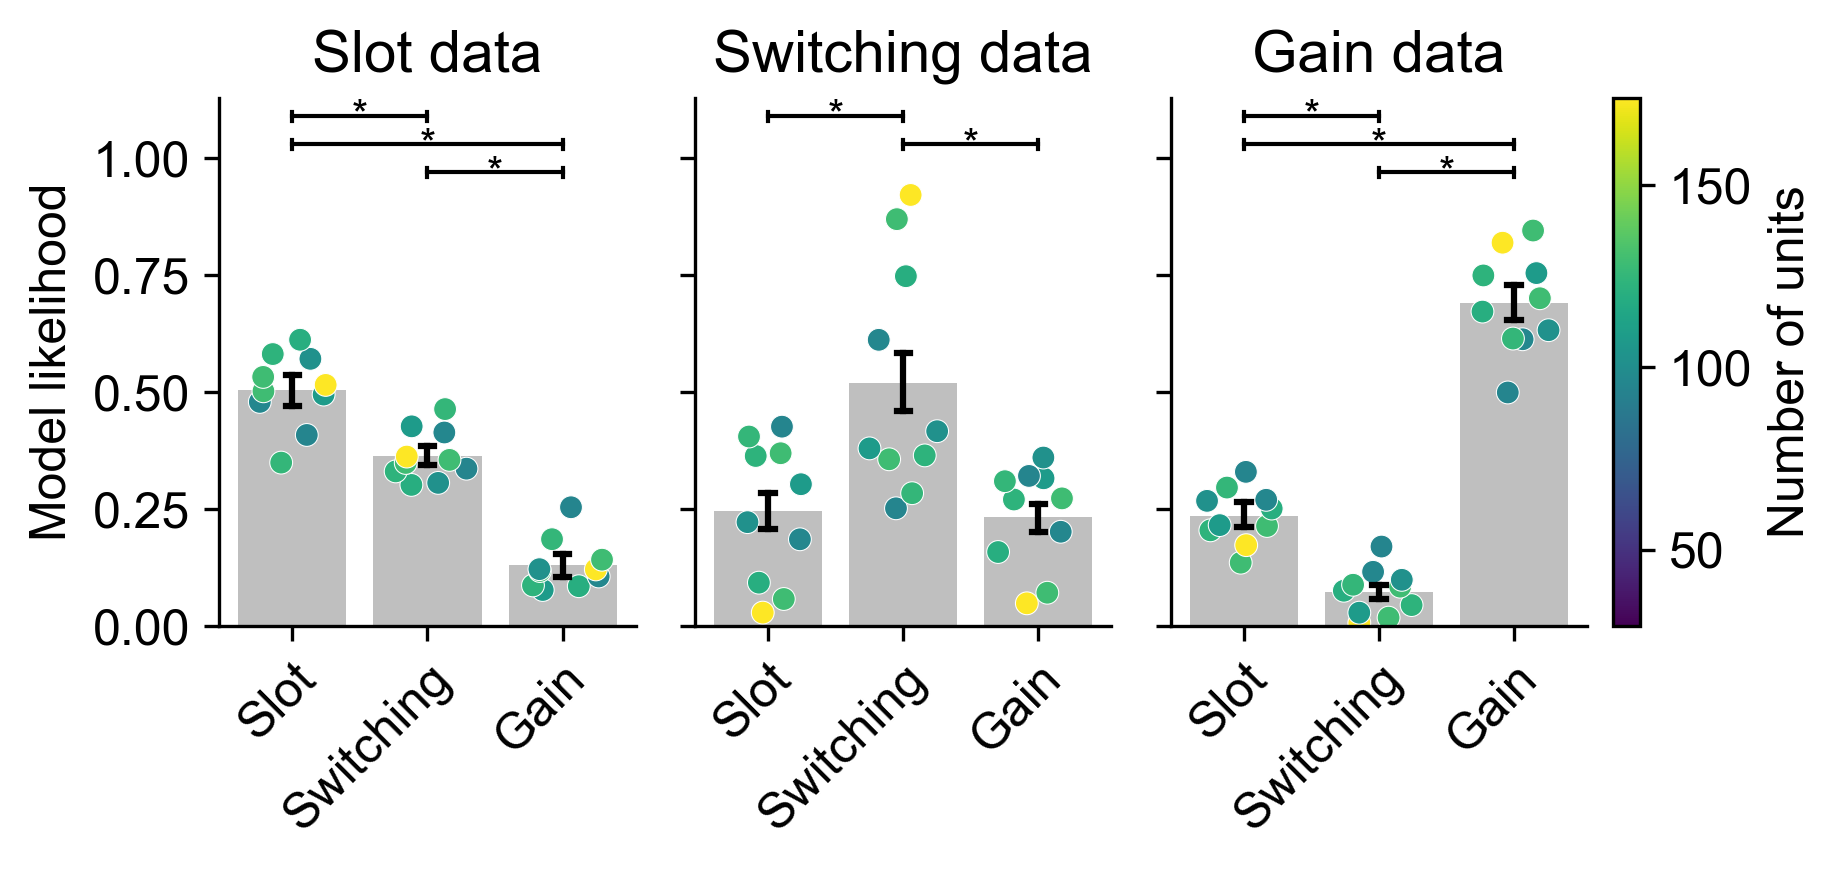

In [30]:
"""Plot."""

np.random.seed(0)  # For reproducibility
num_neuron_range = (29, 174)  # Range of number of neurons in the dataset

def _add_x_jitter(row, y_safezone, parity, jitter=0.15, jitter_safezone=0.15):
    """Add x-jitter to row."""
    sample = np.random.uniform(0, jitter)
    prob = row["prob"]
    if prob > y_safezone[0] and prob < y_safezone[1]:
        sample += jitter_safezone
    if parity == 0:
        sample = -sample
    return sample

fig, axes = plt.subplots(
    1, 3, figsize=(6.2, 3), sharey=True, width_ratios=[1, 1, 1.25],
)
datasets = data_df['dataset'].unique()
for ax, dataset in zip(axes, datasets):
    sns.despine(ax=ax)
    ax.set_title(f"{dataset} data")
    dataset_df = data_df[data_df.dataset == dataset]
    
    # Barplot of probabilities
    sns.barplot(
        data=dataset_df,
        ax=ax,
        x="model",
        y="prob",
        zorder=0,
        color=(0.75, 0.75, 0.75),
        err_kws={'color': 'k', 'linewidth': 1.5},
        capsize=0.1,
    )
    
    # Add scatterplot of means
    mean_per_session_df = dataset_df.groupby(["model", "session"])[["num_neurons", "prob"]].mean().reset_index()
    mean_per_session_df = mean_per_session_df.sort_values(by=["model", "prob"]).reset_index(drop=True)
    mean_per_session_df["model"] = mean_per_session_df["model"].map(
        {name: i for i, name in enumerate(MODEL_ORDER)})
    for i in range(3):
        y_mean = np.mean(mean_per_session_df[mean_per_session_df["model"] == i]["prob"])
        y_ci = scipy_stats.sem(mean_per_session_df[mean_per_session_df["model"] == i]["prob"]) * 1.96
        y_safezone = (y_mean - y_ci - 0.01, y_mean + y_ci + 0.01)
        for j, row in mean_per_session_df[mean_per_session_df["model"] == i].iterrows():
            parity = j % 2
            mean_per_session_df.loc[j, "model"] += _add_x_jitter(
                row,
                y_safezone,
                parity,
            )
    sns.scatterplot(
        data=mean_per_session_df,
        x="model",
        y="prob",
        hue="num_neurons",
        ax=ax,
        zorder=1,
        linewidth=0.25,
        legend=False,
        palette="viridis",
        s=30,
        hue_norm=plt.Normalize(vmin=num_neuron_range[0], vmax=num_neuron_range[1])
    )
    
    # Plot significance brackets with stars
    count = 0
    for i, model1 in enumerate(MODEL_ORDER):
        for j, model2 in enumerate(MODEL_ORDER):
            if i >= j:
                continue
            model1_probs = dataset_df[dataset_df["model"] == model1]["prob"]
            model2_probs = dataset_df[dataset_df["model"] == model2]["prob"]
            model1_probs = model1_probs[np.isfinite(model1_probs)]
            model2_probs = model2_probs[np.isfinite(model2_probs)]
            # Perform t-test
            t, p = scipy_stats.ttest_ind(model1_probs, model2_probs)
            if p < 0.01:
                # Add significance brackets
                count += 1
                y = 1.15 - 0.06 * count
                ax.plot([i, j], [y, y], 'k-', lw=1)
                bracket_hw = 0.01
                ax.plot([i, i], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.plot([j, j], [y - bracket_hw, y + bracket_hw], 'k-', lw=1)
                ax.text((i + j) / 2, y - 0.044, "*", ha='center', va='bottom', color='k')
    
    # Add colorbar for number of units
    if dataset == datasets[-1]:
        hues = mean_per_session_df["num_neurons"]
        cmap = plt.cm.get_cmap('viridis')
        norm = plt.Normalize(vmin=num_neuron_range[0], vmax=num_neuron_range[1])
        hues = cmap(norm(hues))
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        y_ticks = [50, 100, 150]
        cbar = fig.colorbar(sm, ax=ax, label="Number of units", ticks=y_ticks)
        cbar.set_label("Number of units")
    
    ax.set_ylabel('Model likelihood')
    ax.set_xlabel('')
    ax.set_ylim(0, 1.13)
    
    # Rotate x-tick labels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor',
    )

# Save figure
fig.tight_layout()
fig.savefig(f"./plots/identifiability.pdf", bbox_inches='tight', pad_inches=0.02)